In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
file = open("dataset.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


In [3]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:360]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.'

In [4]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'One morning  when Gregor Samsa woke from troubled dreams  he found himself transformed in his bed into a horrible vermin   He lay on his armour like back  and if he lifted his head a little he could see his brown belly  slightly domed and divided by arches into stiff sections   The bedding was hardly able to cover it and seemed ready to slide off any moment   His many legs  pitifully thin compared with the size of the rest of him  waved about helplessly as he looked    What s happened to me   he'

In [5]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room altho'

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[17, 53, 293, 2, 18, 729, 135, 730, 294, 8]

In [7]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [8]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729],
       [729, 135],
       [135, 730],
       [730, 294],
       [294,   8],
       [  8, 731]])

In [9]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [10]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [ 17  53 293   2  18]
The responses are:  [ 53 293   2  18 729]


In [11]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             26170     
_________________________________________________________________
lstm (LSTM)                  (None, 1, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 2617)              2619617   
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


In [13]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [15]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001),metrics=['accuracy'])

In [16]:
history = model.fit(X, y, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
61/61 [==============================] - ETA: 0s - loss: 7.8754 - accuracy: 0.0018
Epoch 00001: loss improved from inf to 7.87540, saving model to nextword.h5
61/61 [==============================] - 6s 97ms/step - loss: 7.8754 - accuracy: 0.0018 - lr: 0.0010
Epoch 2/150
61/61 [==============================] - ETA: 0s - loss: 7.8622 - accuracy: 0.0031
Epoch 00002: loss improved from 7.87540 to 7.86217, saving model to nextword.h5
61/61 [==============================] - 6s 93ms/step - loss: 7.8622 - accuracy: 0.0031 - lr: 0.0010
Epoch 3/150
61/61 [==============================] - ETA: 0s - loss: 7.8180 - accuracy: 0.0028
Epoch 00003: loss improved from 7.86217 to 7.81803, saving model to nextword.h5
61/61 [==============================] - 6s 92ms/step - loss: 7.8180 - accuracy: 0.0028 - lr: 0.0010
Epoch 4/150
61/61 [==============================] - ETA: 0s - loss: 7.6458 - accuracy: 0.0039
Epoch 00004: loss improved from 7.81803 to 7.64582, saving model to nextword.h5
6

61/61 [==============================] - 5s 87ms/step - loss: 4.3259 - accuracy: 0.0517 - lr: 0.0010
Epoch 31/150
61/61 [==============================] - ETA: 0s - loss: 4.2554 - accuracy: 0.0550
Epoch 00031: loss improved from 4.32594 to 4.25544, saving model to nextword.h5
61/61 [==============================] - 5s 84ms/step - loss: 4.2554 - accuracy: 0.0550 - lr: 0.0010
Epoch 32/150
61/61 [==============================] - ETA: 0s - loss: 4.2023 - accuracy: 0.0625
Epoch 00032: loss improved from 4.25544 to 4.20227, saving model to nextword.h5
61/61 [==============================] - 5s 83ms/step - loss: 4.2023 - accuracy: 0.0625 - lr: 0.0010
Epoch 33/150
61/61 [==============================] - ETA: 0s - loss: 4.1462 - accuracy: 0.0622
Epoch 00033: loss improved from 4.20227 to 4.14617, saving model to nextword.h5
61/61 [==============================] - 5s 84ms/step - loss: 4.1462 - accuracy: 0.0622 - lr: 0.0010
Epoch 34/150
61/61 [==============================] - ETA: 0s - loss

61/61 [==============================] - ETA: 0s - loss: 2.2889 - accuracy: 0.3016
Epoch 00060: loss improved from 2.34553 to 2.28891, saving model to nextword.h5
61/61 [==============================] - 6s 91ms/step - loss: 2.2889 - accuracy: 0.3016 - lr: 0.0010
Epoch 61/150
61/61 [==============================] - ETA: 0s - loss: 2.2675 - accuracy: 0.3026
Epoch 00061: loss improved from 2.28891 to 2.26747, saving model to nextword.h5
61/61 [==============================] - 5s 88ms/step - loss: 2.2675 - accuracy: 0.3026 - lr: 0.0010
Epoch 62/150
61/61 [==============================] - ETA: 0s - loss: 2.2217 - accuracy: 0.3065
Epoch 00062: loss improved from 2.26747 to 2.22170, saving model to nextword.h5
61/61 [==============================] - 5s 85ms/step - loss: 2.2217 - accuracy: 0.3065 - lr: 0.0010
Epoch 63/150
61/61 [==============================] - ETA: 0s - loss: 2.1665 - accuracy: 0.3260
Epoch 00063: loss improved from 2.22170 to 2.16649, saving model to nextword.h5
61/61 

Epoch 90/150
61/61 [==============================] - ETA: 0s - loss: 1.5385 - accuracy: 0.4531
Epoch 00090: loss improved from 1.57152 to 1.53853, saving model to nextword.h5
61/61 [==============================] - 5s 84ms/step - loss: 1.5385 - accuracy: 0.4531 - lr: 0.0010
Epoch 91/150
61/61 [==============================] - ETA: 0s - loss: 1.5438 - accuracy: 0.4608
Epoch 00091: loss did not improve from 1.53853
61/61 [==============================] - 5s 80ms/step - loss: 1.5438 - accuracy: 0.4608 - lr: 0.0010
Epoch 92/150
61/61 [==============================] - ETA: 0s - loss: 1.5179 - accuracy: 0.4680
Epoch 00092: loss improved from 1.53853 to 1.51789, saving model to nextword.h5
61/61 [==============================] - 5s 84ms/step - loss: 1.5179 - accuracy: 0.4680 - lr: 0.0010
Epoch 93/150
61/61 [==============================] - ETA: 0s - loss: 1.5075 - accuracy: 0.4634
Epoch 00093: loss improved from 1.51789 to 1.50747, saving model to nextword.h5
61/61 [===================

Epoch 120/150
61/61 [==============================] - ETA: 0s - loss: 0.7613 - accuracy: 0.5829
Epoch 00120: loss improved from 0.76516 to 0.76132, saving model to nextword.h5
61/61 [==============================] - 5s 84ms/step - loss: 0.7613 - accuracy: 0.5829 - lr: 2.0000e-04
Epoch 121/150
61/61 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.5791
Epoch 00121: loss improved from 0.76132 to 0.75744, saving model to nextword.h5
61/61 [==============================] - 5s 84ms/step - loss: 0.7574 - accuracy: 0.5791 - lr: 2.0000e-04
Epoch 122/150
61/61 [==============================] - ETA: 0s - loss: 0.7537 - accuracy: 0.5822
Epoch 00122: loss improved from 0.75744 to 0.75372, saving model to nextword.h5
61/61 [==============================] - 5s 84ms/step - loss: 0.7537 - accuracy: 0.5822 - lr: 2.0000e-04
Epoch 123/150
61/61 [==============================] - ETA: 0s - loss: 0.7524 - accuracy: 0.5811
Epoch 00123: loss improved from 0.75372 to 0.75235, savin

Epoch 150/150
61/61 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.5814
Epoch 00150: loss did not improve from 0.66899
61/61 [==============================] - 5s 83ms/step - loss: 0.6704 - accuracy: 0.5814 - lr: 1.0000e-04


In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'lr'])


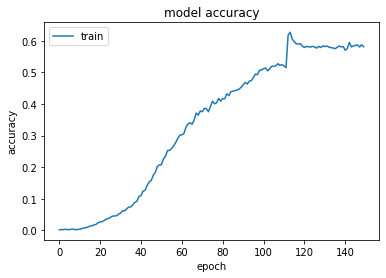

In [18]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

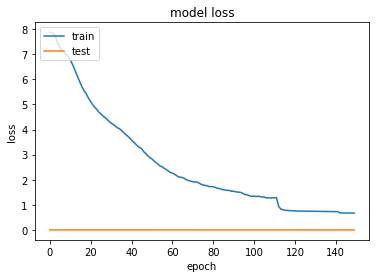

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['lr'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# Importing the Libraries

from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer

model = load_model('nextword.h5')
tokenizer = pickle.load(open('tokenizer1.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  for i in range(3):
    sequence = tokenizer.texts_to_sequences([text])[0]
    sequence = np.array(sequence)
    
    preds = model.predict_classes(sequence)
#         print(preds)
    predicted_word = ""
    
    for key, value in tokenizer.word_index.items():
      if value == preds:
        predicted_word = key
        break
    
    #print(predicted_word)
  return predicted_word

In [ ]:
# EXAMPLES TO TYPE
# text1 = "at the dull"
# text2 = "collection of textile"
# text3 = "what a strenuous"
# text4 = "stop the script"

while(True):
  text = input("Enter your line: ")
    
  if text == "stop":
    print("Ending The Program.....")
    break
  
  else:
    try:
      text = text.split(" ")
      text = text[-1]

      text = ''.join(text)
      pred_word = Predict_Next_Words(model, tokenizer, text)
      print(pred_word)

          
    except:
      continue


Enter your line: at the dull
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
weather
Enter your line: collection of textile
samples
